## Importing Necessary Packages

In [ ]:
!pip install ultralytics

In [ ]:
!pip install pycocotools

In [ ]:
!pip install wandb

In [5]:
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import wandb

%matplotlib inline

## Importing Datasets

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

# Create the Kaggle directory and copy Kaggle API key
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# Set appropriate permissions for the Kaggle API key
! chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the Car Object Detection datasset from Kaggle
!kaggle datasets download -d sshikamaru/car-object-detection
!unzip car-object-detection.zip

## Dataset Splitting

In [8]:
train_imgs_dir="/content/data/training_images"
train_labels="/content/data/train_solution_bounding_boxes (1).csv"

test_imgs_dir="/content/data/testing_images"

In [9]:
imgs_list=list(sorted(os.listdir(train_imgs_dir)))
idxs=list(range(len(imgs_list)))
np.random.shuffle(idxs)

train_idx=idxs[:int(0.8*len(idxs))]
val_idx=idxs[int(0.8*len(idxs)):]

## Converting dataset to YOLO format

In [10]:
# root directory
!mkdir "/content/data"

# images directory
!mkdir "/content/data/images"

# train and test subdirectories with image directory
!mkdir "/content/data/images/train"
!mkdir "/content/data/images/val"

# labels directory
!mkdir "/content/data/labels"

# train and test subdirectories with labels directory
!mkdir "/content/data/labels/train"
!mkdir "/content/data/labels/val"

root_dir="/content/data"
labels_dir="/content/data/labels"
images_dir="/content/data/images"

mkdir: cannot create directory ‘/content/data’: File exists


In [11]:
df = pd.read_csv(train_labels)

width = 676
height = 380

df["class"] = 0
df.rename(columns={'image':'img_name'}, inplace=True)

df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

#normalizing bounding box coordinates
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo.head()

,img_name,class,x_centre,y_centre,width,height
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422


In [12]:
for idx,img_name in enumerate(imgs_list):
    subset="train"
    if idx in val_idx:
        subset="val"

    if np.isin(img_name,df_yolo["img_name"]):
        columns=["class","x_centre","y_centre","width","height"]
        img_bbox=df_yolo[df_yolo["img_name"]==img_name][columns].values

        label_file_path=os.path.join(labels_dir,subset,img_name[:-4]+".txt")
        with open(label_file_path,"w+") as f:
            for row in img_bbox:
                text=" ".join(row.astype(str))
                f.write(text)
                f.write("\n")

    old_image_path=os.path.join(train_imgs_dir,img_name)
    new_image_path=os.path.join(images_dir,subset,img_name)
    shutil.copy(old_image_path,new_image_path)

In [13]:
yolo_format=dict(path="/content/data",
                 train="/content/data/images/train",
                 val="/content/data/images/val",
                 nc=1,
                 names={0:"car"})

with open('/content/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

## Training the model

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
model = YOLO('yolov8m.pt')
model.train(data="/content/yolo.yaml", epochs=50, patience=5, batch=8, lr0=0.0005, imgsz=640)

path_best_weights = "/content/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights)

metrics = model.val()

print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")
print(f"Mean Average Precision @ .50   : {metrics.box.map50}")
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

100%|██████████| 49.7M/49.7M [00:00<00:00, 80.1MB/s]


Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/yolo.yaml, epochs=50, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, ker

100%|██████████| 755k/755k [00:00<00:00, 4.33MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 21.2MB/s]


AMP: checks passed ✅


train: Scanning /content/data/labels/train... 283 images, 517 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<00:00, 2730.82it/s]


train: New cache created: /content/data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/labels/val... 72 images, 129 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<00:00, 1071.43it/s]

val: New cache created: /content/data/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.63G      1.461      1.469      1.255         11        640: 100%|██████████| 100/100 [00:31<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.76it/s]

                   all        201        119      0.896      0.815      0.926      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.77G      1.446       1.21      1.373         14        640: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.59it/s]

                   all        201        119   0.000821      0.387   0.000572   0.000258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.77G      1.533      1.157      1.405          3        640: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]

                   all        201        119      0.897      0.697      0.832      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.77G      1.536      1.064      1.439          2        640: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.28it/s]

                   all        201        119      0.663      0.538      0.584      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.77G      1.533      1.059       1.42         16        640: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.28it/s]

                   all        201        119      0.875      0.823      0.911      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.77G       1.47     0.9307      1.393          6        640: 100%|██████████| 100/100 [00:29<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        201        119      0.881      0.868       0.95      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.76G      1.458     0.9254      1.398         13        640: 100%|██████████| 100/100 [00:29<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        201        119      0.897      0.735      0.805      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.77G      1.399     0.8402      1.347         11        640: 100%|██████████| 100/100 [00:29<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        201        119      0.846      0.923       0.91       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.78G      1.429     0.9465      1.342          7        640: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.17it/s]

                   all        201        119        0.9      0.882      0.937      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.78G      1.396     0.8954      1.312         13        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.31it/s]


                   all        201        119      0.926      0.944      0.969        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.79G      1.385     0.8223      1.307          2        640: 100%|██████████| 100/100 [00:29<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.05it/s]

                   all        201        119      0.908      0.941      0.972      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.76G      1.369     0.7896      1.308         11        640: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]

                   all        201        119      0.948      0.891      0.964      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.76G       1.32     0.8835      1.278         12        640: 100%|██████████| 100/100 [00:29<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.64it/s]

                   all        201        119       0.95      0.908      0.979      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.77G      1.337      0.821      1.301          4        640: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.67it/s]

                   all        201        119      0.884       0.96      0.973      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.77G      1.359     0.7617      1.298         13        640: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

                   all        201        119      0.925      0.958      0.981      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.78G       1.31     0.7314      1.277          8        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]

                   all        201        119      0.898       0.95      0.975       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.77G      1.363     0.7306      1.296          7        640: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]

                   all        201        119      0.921      0.974      0.976      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.78G      1.362     0.7051      1.294          6        640: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        201        119      0.961      0.966      0.985      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.78G      1.291     0.6621      1.248          7        640: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.33it/s]

                   all        201        119      0.942      0.924      0.973      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.77G      1.285     0.6528      1.251         11        640: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.46it/s]

                   all        201        119       0.93      0.966      0.982       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.78G      1.253     0.6496      1.236         10        640: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.41it/s]

                   all        201        119      0.877      0.963       0.97      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.79G      1.251     0.6455      1.244          1        640: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.85it/s]

                   all        201        119      0.912      0.954      0.978       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.79G      1.249     0.6466      1.218         10        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        201        119      0.942      0.952      0.981      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.79G      1.253     0.6339      1.261         13        640: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.10it/s]

                   all        201        119      0.912      0.933      0.968       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.79G      1.305     0.6513      1.252          4        640: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]

                   all        201        119      0.927      0.965      0.982      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.78G      1.218     0.6187      1.207         11        640: 100%|██████████| 100/100 [00:27<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.40it/s]

                   all        201        119      0.942      0.955       0.98      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.78G      1.241     0.6215      1.226          1        640: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]

                   all        201        119      0.908          1      0.985      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.78G      1.231     0.6012      1.222          9        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]

                   all        201        119      0.952       0.95      0.985      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.78G      1.244     0.5803      1.238         12        640: 100%|██████████| 100/100 [00:29<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.03it/s]

                   all        201        119      0.958      0.956      0.987      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.81G       1.23     0.5895      1.198          7        640: 100%|██████████| 100/100 [00:29<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        201        119      0.942      0.962       0.99      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.77G      1.191     0.5624      1.205          3        640: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        201        119      0.944      0.989       0.99      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.78G      1.187     0.5829      1.205         13        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.66it/s]

                   all        201        119      0.966      0.968       0.99      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       3.8G       1.16     0.5458      1.207          5        640: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.77it/s]

                   all        201        119      0.951       0.97       0.99      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.79G      1.145     0.5603      1.178          6        640: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.82it/s]

                   all        201        119       0.95      0.965       0.99      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       3.8G      1.159     0.5486      1.185          8        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.09it/s]

                   all        201        119      0.959      0.976      0.991      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       3.8G      1.136     0.5146      1.167          7        640: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.98it/s]

                   all        201        119      0.952      0.975      0.991      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.79G      1.109     0.5316      1.141          6        640: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]

                   all        201        119      0.942      0.975      0.987      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.78G      1.088     0.5403      1.145          7        640: 100%|██████████| 100/100 [00:29<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]

                   all        201        119      0.959      0.974      0.992      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.79G      1.105     0.5117      1.146         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]

                   all        201        119      0.921      0.981      0.988      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.8G       1.14     0.5256      1.181         11        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.84it/s]


                   all        201        119      0.951      0.976      0.982      0.697
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       3.8G       1.07     0.4952      1.178          3        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.71it/s]

                   all        201        119      0.966      0.966      0.988      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.79G      1.046     0.4679      1.145          7        640: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.95it/s]

                   all        201        119      0.946      0.975      0.983      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       3.8G       1.02     0.4617      1.116          7        640: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]

                   all        201        119      0.958      0.963      0.987      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.79G      1.041     0.4797      1.129          4        640: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

                   all        201        119      0.959      0.978      0.987      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.79G      0.995     0.4478      1.088          7        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]

                   all        201        119      0.943      0.983      0.988      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.78G      1.018     0.4483      1.133          9        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]

                   all        201        119      0.929      0.994      0.987      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.78G      1.012     0.4715      1.109          4        640: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.19it/s]

                   all        201        119      0.943      0.992      0.989       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.79G      1.023     0.4703      1.107          0        640: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]

                   all        201        119      0.942      0.992      0.988      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.79G     0.9446     0.4879      1.048          2        640: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.01it/s]

                   all        201        119      0.944      0.988      0.989       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.79G      1.019     0.4575      1.107          1        640: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.02it/s]

                   all        201        119      0.947      0.983      0.988      0.702



50 epochs completed in 0.465 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


                   all        201        119      0.943      0.992      0.989      0.711
Speed: 0.5ms preprocess, 7.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),█▁▇▅█▇▇█████████████████████████████████
metrics/mAP50-95(B),▆▁▅▄▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
metrics/precision(B),▇▁▇▆▇▇▇████▇████▇███████████████████████
metrics/recall(B),▆▁▅▃▆▅▇▇▇▇▇█▇██▇█▇▇▇▇█▇█████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▇▇██▇▇▆▇▆▆▅▅▅▆▆▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁


Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/data/labels/val.cache... 72 images, 129 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


                   all        201        119      0.943      0.992      0.989      0.709
Speed: 0.4ms preprocess, 13.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val
Mean Average Precision @.5:.95 : 0.7086343449119865
Mean Average Precision @ .50   : 0.9886675586442282
Mean Average Precision @ .70   : 0.8869195183552657


## Visualizing Predictions

In [16]:
with torch.no_grad():
    results=model.predict(source=test_imgs_dir,conf=0.50,iou=0.75)


image 1/175 /content/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 266.1ms
image 2/175 /content/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 25.8ms
image 3/175 /content/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 25.8ms
image 4/175 /content/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 25.8ms
image 5/175 /content/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 25.8ms
image 6/175 /content/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 20.1ms
image 7/175 /content/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 20.1ms
image 8/175 /content/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 20.1ms
image 9/175 /content/data/testing_images/vid_5_25260.jpg: 384x640 (no detections), 20.1ms
image 10/175 /content/data/testing_images/vid_5_26320.jpg: 384x640 (no detections), 20.1ms
image 11/175 /content/data/testing_images/vid_5_26400.jpg: 384x640 (no detections), 20.2ms
image 

In [20]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [21]:
! mkdir "/content/predictions"

prediction_dir="/content/predictions"
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()

        test_img_list.append(name)

        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

In [22]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    axis.imshow(img)
    axis.axis("off")

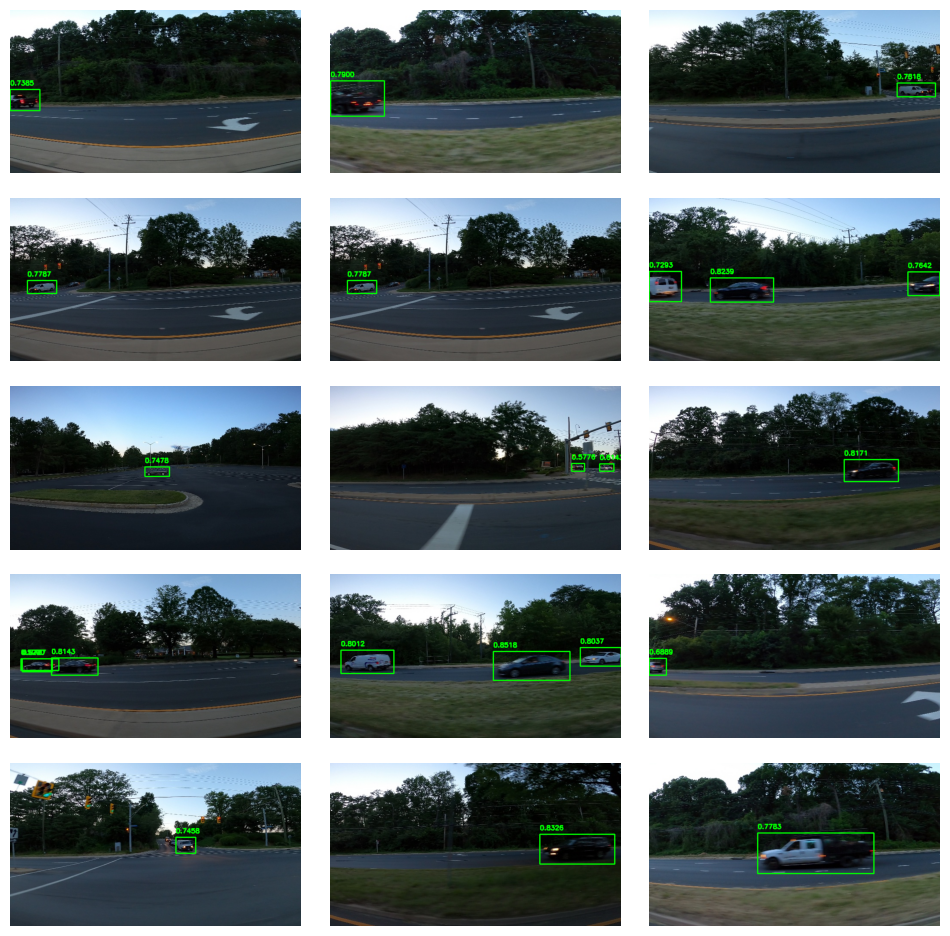

In [23]:
fig,axes=plt.subplots(5,3,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,15)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_imgs_dir,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])